# GAIA distance calculator

In [1]:
import numpy as np
from astropy import units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from scipy.integrate import simps
import emcee
import corner

import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 22})

## Query of database

You can query the Gaia DR2 database through gaia.tap (only works)
on python 2.7

In [2]:
c = SkyCoord('02 43 40.4373 +61 26 03.713', unit=(u.hourangle, u.deg))

In [3]:
#Search for the source in a 10 arcsec radius using gaia tap
# python interface:
#from gaia.tap import cone_search,query
#ga = cone_search(c.ra.deg, c.dec.deg, 10/3600.,
#                 table='gaiadr2.gaia_source')

## Change the parameters here!!!
Once you have the parallax and its uncertanity,
change the cell below. 
Also, change the length scale and the zero-point.
This should be the only parameters you need to change
before running the notebook.

In [1]:
parallax, error = 0.0952,0.0302
L = 1.3 #kpc
w_zp = -0.029 # zero point, Lindegren+2018

## Distance estimate

Setting up the likelihood model, as suggested in Bailer-Jones+2018

with a global parallax zeropoint, $\varpi_{zp}=-0.029$ mas, from Lindegren, et al. 2018 ArXiv:1804.09366  (http://adsabs.harvard.edu/abs/2018arXiv180409366L)

$\ln[P(\varpi|r,\sigma_{\varpi})] = \frac{1}{2\sigma_{\varpi}^2}(\varpi - \varpi_{zp} - \frac{1}{r})^2 - \ln(\sqrt{2\pi} \sigma_{\varpi})$

In [3]:
def lnlike(theta, y, yerr):
    distance = theta
    model = 1. / distance
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-w_zp-model)**2*inv_sigma2 \
            - np.log(inv_sigma2)))

We use the exponentially decreasing volume density prior, from Bailer-Jones 2015 (http://adsabs.harvard.edu/abs/2015PASP..127..994B)

$P(r)=\frac{1}{2L^3}r^2e^{-r/L}$, for $r>0$

where L=1.35 kpc, is the lenght scale. This length scale can be adjusted, however the latter value is suggested in Astraatmadja & Bailer-Jones 2016 (http://adsabs.harvard.edu/abs/2016ApJ...832..137A)

Higher values of L tend to give larger distances.

In [4]:
def lnprior_exp(theta):
    distance = theta
    if  distance > 0:
        prior = distance**2 * np.exp(-distance/L) /(2.0 * L**3)
        return np.log(prior)
    return -np.inf 

Set-up the full unnormalised posterior distribution

In [5]:
def lnprob_exp(theta, y, yerr):
    lp = lnprior_exp(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, y, yerr)

The function that performs the sampling of the posterior 
distribution with EMCEE (Foreman-Mackay+ 2013) in order to obtain the quartiles http://adsabs.harvard.edu/abs/2013PASP..125..306F

In [6]:
def gaia_exp(par,par_error,samp_out=True, burn_in=500, num_chains=2000):
    ndim, nwalkers = 1, 60
    pos = [1./par + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_exp, args=(par,par_error),threads=1)
    sampler.run_mcmc(pos, num_chains)
    samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))

    q05 = corner.quantile(samples,.05)
    q50 = corner.quantile(samples,.50)
    q95 = corner.quantile(samples,.95)
    if samp_out:
        return q05[0], q50[0], q95[0],samples
    else:
        return q05[0], q50[0], q95[0]

Now, using the parallax and error measurement from Gaia DR2

In [8]:
frac = error/parallax

print("sig/parallax={:.3f}".format(error/parallax))
print("")
print("d_naive={:.3f} ± {:.3f} kpc".format(1/parallax,error/parallax**2))



sig/parallax=0.317

d_naive=10.504 ± 3.332 kpc


We calculate the 5, 50 and 95 percentile

In [9]:
q05,q50,q95,samples_exp = gaia_exp(parallax, error,
                          burn_in=500, num_chains=8000)

In [10]:
print(" 5 percentile = {:.2f}\n \
50 percentile = {:.2f}\n \
95 percentile = {:.2f}".format(q05,q50,q95))

 5 percentile = 5.52
 50 percentile = 7.28
 95 percentile = 10.21


In [11]:
print("d={:.2f} + {:.2f} - {:.2f} kpc".format(q50,q95-q50,q50-q05))
q01 = corner.quantile(samples_exp,1-.99)
print("Distance lower limit 1%={:.2f} kpc".format(q01[0]))

d=7.28 + 2.94 - 1.76 kpc
Distance lower limit 1%=5.01 kpc


We can find analytically the mode of the distribution, from Bailer-Jones 2015

In [12]:
coeff = [  1/L,-2,(parallax - w_zp)/error**2,-1/error**2 ]
roots = np.roots(coeff)
#print(roots)
ss = np.imag(roots) == 0
mode_d = np.real(roots[ss])[0]
print("r_Mode = {:.2f} kpc".format(mode_d))

r_Mode = 6.90 kpc


Calculate the evidence Z = $\int^{\infty}_0P(\varpi|r,\sigma_{\varpi})P(r)$

In [13]:
xx = np.linspace(0.0,100,1e3)
yy = np.zeros(xx.size)
for i, xo in enumerate(xx):
    yy[i] = np.exp(lnprob_exp(xo,parallax,error))
Z = simps(yy,x=xx)
print("Z={:.3e}".format(Z))

# Now, let's create the 90% lower limit curve for plotting purposes
xx90= np.linspace(q01,50,1e3)
yy90 = np.zeros(xx90.size)
for i, xo in enumerate(xx90):
    yy90[i] = np.exp(lnprob_exp(xo,parallax,error))

Z=4.569e+00


/Users/juan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.
/Users/juan/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


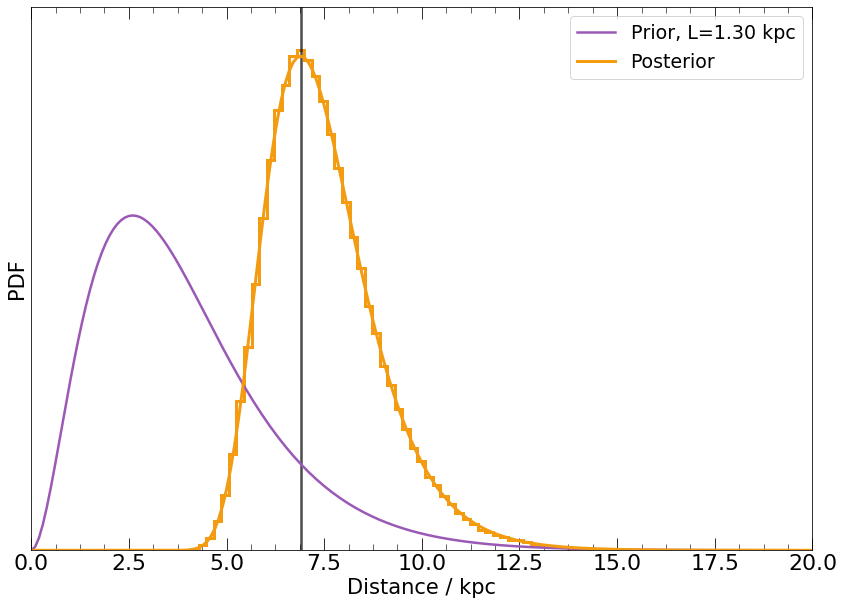

In [14]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
a = plt.hist(samples_exp,bins=100,color='#f39c12',lw=3,histtype='step',
             normed=True,)

plt.axvline(x=mode_d,ls='-',color='k',alpha=0.7,lw=2.5)

plt.plot(xx,(1/(2*L**3))*np.exp(-xx/L)*xx**2,
         label='Prior, L={:.2f} kpc'.format(L),
         color='#9b59b6',lw=2.5)
plt.plot(xx,yy/Z,lw=3,color='#f39c12',label='Posterior')



plt.xlim(0,20)
plt.ylim(0,max(yy/Z)*1.1)

ax.set_yticklabels([])
ax.set_yticks([])
lg = plt.legend(fontsize=19)
plt.xlabel("Distance / kpc")
plt.ylabel('PDF')